# Music Therapy Investigation

The purpose of this analysis is to discover trends in music therapy which might help improve the practice. Particularly of interest is the preferred genre of music of patients, and how it relates to the success of the treatment. If a clear trend could be established, this could help enhance music therapy practice for others in the future. A few other relationships can be explored as well, such as the effect of the average BPM of their favorite genre on the success of their treatment, and the frequency with which they listen to various genres.

## Null and Alternative Hypotheses

**Null Hypothesis**: The success of music therapy treatment does not depend on the musical selection or any other musical factors.

**Alternative Hypothesis**: Choice of musical genre does have an impact on the success of music therapy treatment.

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np

# Visualization libraries

import matplotlib.pyplot as plt
import seaborn as sns

# Statistics libraries

import statsmodels as sum
from scipy.stats import f_oneway, chi2_contingency

# Machine Learning libraries

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
# Set a random_state number to be used throughout the analysis

random_state = 42

In [3]:
# Import cleaned data

survey_df = pd.read_csv('../data/interim/clean_survey_results.csv')
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Rarely,Never,Rarely,Rarely,Very frequently,7,7,10,2,No effect
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Sometimes,Sometimes,Never,Never,Never,9,7,3,3,Improve
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Sometimes,Very frequently,Very frequently,Never,Rarely,7,2,5,9,Improve
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Very frequently,Very frequently,Never,8,8,7,7,Improve
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Rarely,Rarely,Never,Never,Sometimes,4,8,6,0,Improve


# Exploring BPM

Being one of the few continuous variables in this dataset, understanding this column could help develop effective predictive models. Its relationship with genre is particularly of interest. If there is a relationship between BPM and genre, then it can be effective in predicting Music effects.

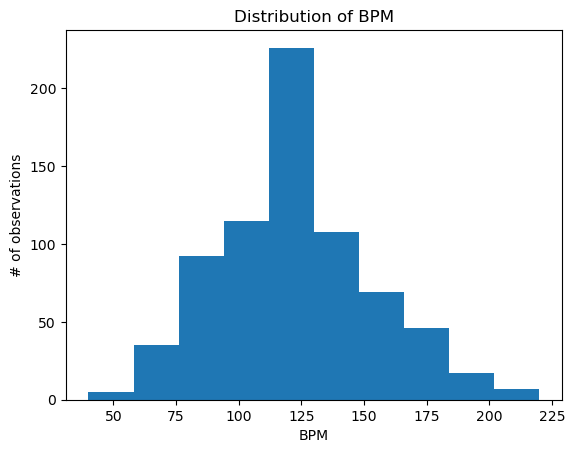

In [4]:
# Visualize overall distribution of BPM

plt.hist(survey_df['BPM'])
plt.xlabel('BPM')
plt.ylabel('# of observations')
plt.title('Distribution of BPM')

plt.show()

BPM appears to be normally distributed across the dataset. Let's see how it's distributed grouped by genre.

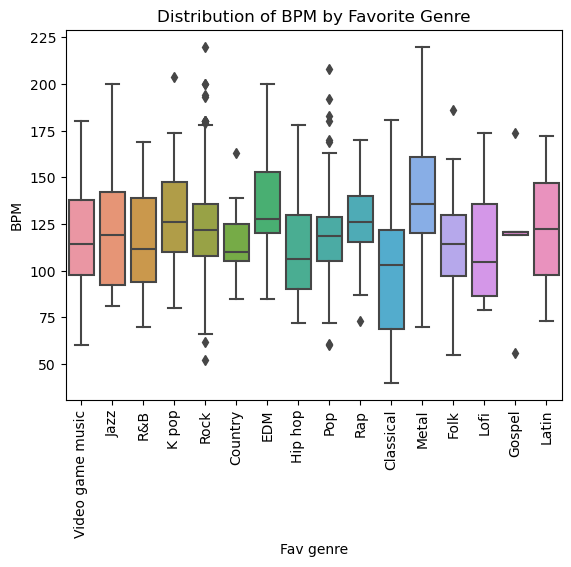

In [5]:
# Visualize distribution of BPM by genre

sns.boxplot(x='Fav genre', y='BPM', data=survey_df)

plt.xticks(rotation=90)
plt.title('Distribution of BPM by Favorite Genre')

plt.show()

This figure reveals that the median BPM of each genre does lie somewhere between 100 and 130. Some genres, such as Classical, have a much wider IQR, implying that data is less clustered around the median and more dispersed. Some genres have highly right-skewed BPM, such as Lofi and Jazz. 

The figure also reveals that very few respondents selected Gospel as their favorite genre, and that Pop and Rock have the most outlying BPM.

We'll use an ANOVA test to test whether statistically significant differences exist in BPM between genres.

### ANOVA Test

Null hypothesis: There is no significant difference in mean BPM per genre.

Alternative hypothesis: At least one genre has a significantly different mean BPM from the other groups.

In [6]:
# Separate data by genre
genres = survey_df['Fav genre'].unique()
bpm_groups = [survey_df[survey_df['Fav genre'] == genre]['BPM'] for genre in genres]

# Perform one-way ANOVA
f_stat, p_value = f_oneway(*bpm_groups)

print(f"F-statistic: {f_stat}, p-value: {p_value}")

F-statistic: 4.9092158286651095, p-value: 3.384358972161804e-09


The p-value represents the probability that a large difference in mean BPM was observed purely by chance between genres. Since this is very low, this means we can reject the null hypothesis and conclude that there is a statistically significant difference between mean BPM.

The f-statistic is relatively large, implying that there is more variation between genre mean BPMs rather than within each genre.

# Music Effects for Musicians

Musicians have an entirely different way of absorbing and experiencing music. This is in part due to their training, which exposes them to different methods of listening to music and especially analyzing it. It is worth exploring, in that case, if the outcomes of music therapy are different for these groups. For the purposes of this test, `Instrumentalist` and `Composer` columns will be combined into a `Musician` column. This column will contain a 1 if they are an Instrumentalist, meaning they play an instrument, or a Composer, meaning they compose music, and a 0 otherwise. Then we will perform a chi-squared test with a significance level of 0.05 to compare this column with `Music effects` in order to see if these columns are independent of one another or not.

**Null Hypothesis**: Being a musician does not have any relationship to the outcome of music therapy treatment.

**Alternative Hypothesis**: Being a musician will have a significant impact on the success ofmusic therapy treatment.

In [7]:
# Create Musician column

survey_df['Musician'] = ((survey_df['Instrumentalist'] == 'Yes') | (survey_df['Composer'] == 'Yes')).astype('str')
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Musician
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Never,Rarely,Rarely,Very frequently,7,7,10,2,No effect,False
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Sometimes,Never,Never,Never,9,7,3,3,Improve,True
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Very frequently,Very frequently,Never,Rarely,7,2,5,9,Improve,False
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Very frequently,Never,8,8,7,7,Improve,True
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Rarely,Never,Never,Sometimes,4,8,6,0,Improve,True


In [8]:
# Calculate proportion of musicians to nonmusicians by music effects in order to plot

counts = survey_df.groupby(['Music effects', 'Musician']).size().reset_index(name='Count')
totals = survey_df.groupby('Music effects')['Musician'].count().reset_index(name='Total')
merged_df = pd.merge(counts, totals)
merged_df['Proportion'] = (merged_df['Count'] / merged_df['Total'])

merged_df

,Music effects,Musician,Count,Total,Proportion
0,Improve,False,319,536,0.595149
1,Improve,True,217,536,0.404851
2,No effect,False,124,167,0.742515
3,No effect,True,43,167,0.257485
4,Worsen,False,13,17,0.764706
5,Worsen,True,4,17,0.235294


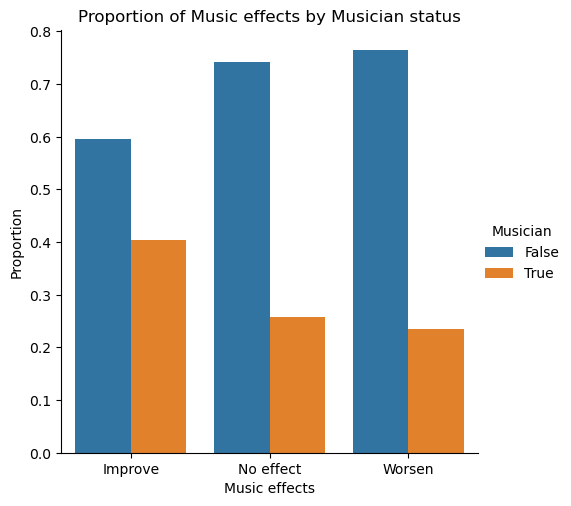

In [9]:
# Plot data

sns.catplot(data=merged_df, x='Music effects', y='Proportion', hue='Musician', kind='bar')

plt.title('Proportion of Music effects by Musician status')

plt.show()

This plot reveals that being a musician does not result in a higher proportion of improvement than for nonmusicians. It does, however, show nonmusicians are significantly more likely to worsen after music therapy treatment than musicians.

In [10]:
# Create contingency table

contingency_table = pd.crosstab(survey_df['Music effects'], survey_df['Musician'])
print(contingency_table)

Musician       False  True
Music effects             
Improve          319   217
No effect        124    43
Worsen            13     4


This contingency table reveals that there are only 4 cases where a musician's treatment worsened. According to the documentation of the scipy chi-squared test, this test is only valid if the observed frequencies in each cell are at least 5. To mitigate this, we will apply bootstrapping to the data to increase our sample size, and then re-evaluate the data to perform this test.

In [11]:
# Bootstrap data with n=2,000

bootstrapped_survey = pd.concat([survey_df, survey_df.sample(n=2000, replace=True, random_state=random_state)])
bootstrapped_survey.shape

(2720, 31)

In [12]:
# Calculate proportions in bootstrapped data

counts = bootstrapped_survey.groupby(['Music effects', 'Musician']).size().reset_index(name='Count')
totals = bootstrapped_survey.groupby('Music effects')['Musician'].count().reset_index(name='Total')
merged_df = pd.merge(counts, totals)
merged_df['Proportion'] = (merged_df['Count'] / merged_df['Total'])

merged_df

,Music effects,Musician,Count,Total,Proportion
0,Improve,False,1221,2022,0.603858
1,Improve,True,801,2022,0.396142
2,No effect,False,482,630,0.765079
3,No effect,True,148,630,0.234921
4,Worsen,False,50,68,0.735294
5,Worsen,True,18,68,0.264706


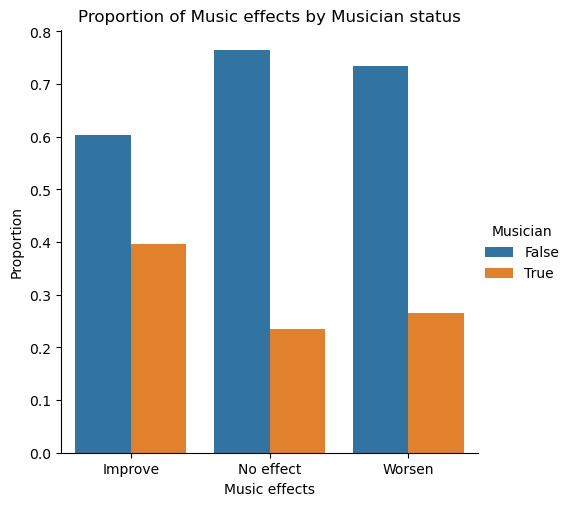

In [13]:
# Plot data

sns.catplot(data=merged_df, x='Music effects', y='Proportion', hue='Musician', kind='bar')

plt.title('Proportion of Music effects by Musician status')

plt.show()

This plot reveals the same information as the original survey data.

In [14]:
# Re-create contingency table with bootstrapped sample

contingency_table = pd.crosstab(bootstrapped_survey['Music effects'], bootstrapped_survey['Musician'])
contingency_table

Musician,False,True
Music effects,,
Improve,1221,801
No effect,482,148
Worsen,50,18


In [15]:
# Run chi-squared test using bootstrapped contingency table

chi2, p, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-squared test statistic: {chi2}, P-value: {p}")

Chi-squared test statistic: 57.00113604629095, P-value: 4.191414161814811e-13


The calculated p-value is significantly low, while the test statistic is relatively high. This allows us to reject the null hypothesis that there is no relationship between being a musician and success of music therapy treatment.

# Effectiveness of Treatment for Patients with Anxiety, Depression, Insomnia, and OCD

It is of particular interest if a significant proportion of individuals suffering with these conditions saw improvement through music therapy. If so, music therapy can be proven to be a viable treatment option for these conditions which often are treated through medications or more aggressive treatments.

We are only interested in whether or not these individuals saw improvement following treatment. Therefore, we will add a new column called `Improve`, which will contain `True` for when a patient saw improvement, and `False` otherwise. We will also equally divide the `Anxiety`, `Depression`, `Insomnia`, and `OCD` columns into three bins labelled Mild, Moderate, and Severe. A chi-squared test with a significance level of 0.05 will be implemented in order to examine the relationship between these columns.

**Null Hypothesis**: The effects of music therapy were the same for all patients, regardless of Anxiety, Depression, Insomnia, or OCD levels.

**Alternative Hypothesis**: The effects of music therapy vary depending on the patients Anxiety, Depression, Insomnia, or OCD levels.

In [16]:
# Create Improve column which represents whether the patient improved or not

survey_df['Improve'] = (survey_df['Music effects'] == 'Improve').astype(str)
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Musician,Improve
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Rarely,Rarely,Very frequently,7,7,10,2,No effect,False,False
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Never,Never,Never,9,7,3,3,Improve,True,True
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Very frequently,Never,Rarely,7,2,5,9,Improve,False,True
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Never,8,8,7,7,Improve,True,True
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Never,Never,Sometimes,4,8,6,0,Improve,True,True


In [17]:
# Collapse data into three bins: Mild, Moderate, and Severe

cols_to_bin = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
group_names = ['Mild', 'Moderate', 'Severe']

for col in cols_to_bin:
    survey_df[col] = pd.cut(survey_df[col], bins=3, labels=group_names)

survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Rap],Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Musician,Improve
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Rarely,Rarely,Very frequently,Severe,Severe,Severe,Mild,No effect,False,False
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Never,Never,Never,Severe,Severe,Mild,Mild,Improve,True,True
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Very frequently,Never,Rarely,Severe,Mild,Moderate,Severe,Improve,False,True
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Very frequently,Never,Severe,Severe,Severe,Severe,Improve,True,True
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Never,Never,Sometimes,Moderate,Severe,Moderate,Mild,Improve,True,True


In [18]:
# Create contingency tables and conduct chi-squared tests

contingency_tables = {}

for col in cols_to_bin:
    contingency_table = pd.crosstab(survey_df[col], survey_df['Improve'])
    contingency_tables[col] = contingency_table
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test statistic for {col}: {round(chi2, 2)}, P-value: {p}")

Chi-squared test statistic for Anxiety: 15.75, P-value: 0.0003804516426358323
Chi-squared test statistic for Depression: 3.58, P-value: 0.16675409746475567
Chi-squared test statistic for Insomnia: 1.44, P-value: 0.48714986974722807
Chi-squared test statistic for OCD: 5.07, P-value: 0.07943737343827363


In [19]:
# Pull up contingency table for Anxiety

contingency_tables['Anxiety']

Improve,False,True
Anxiety,,
Mild,64,109
Moderate,44,150
Severe,76,277


Based on these results we can only reject the null hypothesis for Anxiety levels. This feature seems to be associated with improvement. We cannot reject the null hypothesis for Depression, Insomnia, nor OCD.

## Negative Effects

Since we were not able to reject the null hypothesis for 3 out of 4 of the listed conditions, we will investigate if those three conditions are related to negative effects due to the therapy. In order to do this, we will make a new column called `Worsen`, which will contain `True` values for when a patient worsened due to the treatment, and `False` otherwise. Then we will conduct chi-squared tests comparing the two in order to see if there is a relationship there.

**Null hypothesis**: A patient's level of Depression, Insomnia, or OCD has no relationship with their music therapy treatment outcome.

**Alternative hypothesis**: A patient's level of Depression, Insomnia, or OCD is related to worsenned effects of music therapy treatment.

In [20]:
# Create worsen column

survey_df['Worsen'] = survey_df['Music effects'] == 'Worsen'
survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,BPM,Frequency [Classical],...,Frequency [Rock],Frequency [Video game music],Anxiety,Depression,Insomnia,OCD,Music effects,Musician,Improve,Worsen
0,18,4.0,No,No,No,Video game music,No,Yes,132.0,Never,...,Rarely,Very frequently,Severe,Severe,Severe,Mild,No effect,False,False,False
1,61,2.5,Yes,No,Yes,Jazz,Yes,Yes,84.0,Sometimes,...,Never,Never,Severe,Severe,Mild,Mild,Improve,True,True,False
2,18,4.0,Yes,No,No,R&B,Yes,No,107.0,Never,...,Never,Rarely,Severe,Mild,Moderate,Severe,Improve,False,True,False
3,18,5.0,Yes,Yes,Yes,Jazz,Yes,Yes,86.0,Rarely,...,Very frequently,Never,Severe,Severe,Severe,Severe,Improve,True,True,False
4,18,3.0,Yes,Yes,No,Video game music,Yes,Yes,66.0,Sometimes,...,Never,Sometimes,Moderate,Severe,Moderate,Mild,Improve,True,True,False


In [21]:
# Create contingency tables and conduct chi-squared tests

cols = ['Depression', 'Insomnia', 'OCD']
contingency_tables = {}

for col in cols:
    contingency_table = pd.crosstab(survey_df[col], survey_df['Worsen'])
    contingency_tables[col] = contingency_table
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test statistic for {col}: {round(chi2, 2)}, P-value: {p}")

Chi-squared test statistic for Depression: 7.86, P-value: 0.019635700929197156
Chi-squared test statistic for Insomnia: 0.91, P-value: 0.6356902928300748
Chi-squared test statistic for OCD: 0.32, P-value: 0.8507076744079226


In [22]:
# Pull up contingency table for Depression

contingency_tables['Depression']

Worsen,False,True
Depression,,
Mild,270,2
Moderate,196,4
Severe,237,11


We are able to reject the null hypothesis for patients with Depression, meaning a patient's level of Depression does relate to them feeling worse after treatment. We are unable to reject the null hypothesis for Insomnia and OCD however.

# Model Preprocessing

Although much of the preprocessing necessary was done in the preprocessing notebook, some, such as converting certain columns to type category, will be done here. This is in preparation for using prediction models.

In [23]:
# Load preprocessed data

ml_survey_df = pd.read_csv('../data/processed/pre_processed_survey_results.csv')
ml_survey_df.head()

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,fav_Jazz,fav_K pop,fav_Latin,fav_Lofi,fav_Metal,fav_Pop,fav_R&B,fav_Rap,fav_Rock,fav_Video game music
0,18,4.0,0,0,0,0,1,132.0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,61,2.5,1,0,1,1,1,84.0,2,0,...,1,0,0,0,0,0,0,0,0,0
2,18,4.0,1,0,0,1,0,107.0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,18,5.0,1,1,1,1,1,86.0,1,2,...,1,0,0,0,0,0,0,0,0,0
4,18,3.0,1,1,0,1,1,66.0,2,0,...,0,0,0,0,0,0,0,0,0,1


## Datatype Conversions

In [24]:
# Convert While working, Instrumentalist, Composer, Fav genre, Exploratory, Anxiety, Depression, Insomnia, OCD, Music effects, and Foreign languages to type category.

columns_to_convert = ['While working', 'Instrumentalist', 'Composer', 'Exploratory', 'Foreign languages', 'Anxiety', 'Depression', 'Insomnia', 'OCD']

ml_survey_df[columns_to_convert] = ml_survey_df[columns_to_convert].astype('category')

In [25]:
# Convert Frequency columns into category

frequency_columns = list(ml_survey_df.columns[ml_survey_df.columns.str.startswith('Fr')])
ml_survey_df[frequency_columns] = ml_survey_df[frequency_columns].astype('category')

ml_survey_df[frequency_columns]

,Frequency [Classical],Frequency [Country],Frequency [EDM],Frequency [Folk],Frequency [Gospel],Frequency [Hip hop],Frequency [Jazz],Frequency [K pop],Frequency [Latin],Frequency [Lofi],Frequency [Metal],Frequency [Pop],Frequency [R&B],Frequency [Rap],Frequency [Rock],Frequency [Video game music]
0,0,0,3,0,0,1,1,3,0,2,2,1,0,1,1,3
1,2,0,0,1,2,0,3,2,3,2,0,2,2,0,0,0
2,0,0,1,0,1,3,0,3,2,2,0,2,3,3,0,1
3,1,2,0,0,0,2,3,3,1,3,1,3,3,3,3,0
4,2,0,1,2,1,1,2,0,1,1,1,1,1,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,3,1,0,2,0,2,1,0,2,1,1,3,0,1,3,0
716,1,1,0,0,0,0,1,0,0,1,0,3,0,0,2,2
717,1,2,2,1,1,3,1,1,1,2,1,2,2,2,1,1
718,3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2


In [26]:
# Confirm all conversions

ml_survey_df.dtypes

Age                                int64
Hours per day                    float64
While working                   category
Instrumentalist                 category
Composer                        category
Exploratory                     category
Foreign languages               category
BPM                              float64
Frequency [Classical]           category
Frequency [Country]             category
Frequency [EDM]                 category
Frequency [Folk]                category
Frequency [Gospel]              category
Frequency [Hip hop]             category
Frequency [Jazz]                category
Frequency [K pop]               category
Frequency [Latin]               category
Frequency [Lofi]                category
Frequency [Metal]               category
Frequency [Pop]                 category
Frequency [R&B]                 category
Frequency [Rap]                 category
Frequency [Rock]                category
Frequency [Video game music]    category
Anxiety         

# Logistic Regression

In [27]:
# Scale Age, Hours per day, and BPM

cols_to_scale = ['Age', 'Hours per day', 'BPM']

# Initialize Scaler 

scaler = StandardScaler()

# Fit scaler

ml_survey_df[cols_to_scale] = scaler.fit_transform(ml_survey_df[cols_to_scale])
ml_survey_df

,Age,Hours per day,While working,Instrumentalist,Composer,Exploratory,Foreign languages,BPM,Frequency [Classical],Frequency [Country],...,fav_Jazz,fav_K pop,fav_Latin,fav_Lofi,fav_Metal,fav_Pop,fav_R&B,fav_Rap,fav_Rock,fav_Video game music
0,-0.599385,0.131555,0,0,0,0,1,0.320697,0,0,...,0,0,0,0,0,0,0,0,0,1
1,3.070901,-0.361006,1,0,1,1,1,-1.239520,2,0,...,1,0,0,0,0,0,0,0,0,0
2,-0.599385,0.131555,1,0,0,1,0,-0.491916,0,0,...,0,0,0,0,0,0,1,0,0,0
3,-0.599385,0.459928,1,1,1,1,1,-1.174511,1,2,...,1,0,0,0,0,0,0,0,0,0
4,-0.599385,-0.196819,1,1,0,1,1,-1.824601,2,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
715,-0.684741,-0.525192,1,1,0,1,1,-0.069358,3,1,...,0,0,0,0,0,0,0,0,1,0
716,-0.599385,-0.853566,1,1,0,1,1,1.230823,1,1,...,0,0,0,0,0,1,0,0,0,0
717,-0.514030,0.788302,1,0,1,1,0,-0.069358,1,2,...,0,0,0,0,0,0,0,1,0,0
718,-0.514030,0.459928,1,1,0,0,0,1.555868,3,0,...,0,0,0,0,0,0,0,0,0,0


## Predicting Worsen

In [28]:
# Separate data in dependent and explanatory variables

X = ml_survey_df.drop('No effect', axis=1)
y = ml_survey_df['No effect']

# Split data in training and testing data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

# Set up cross-validation and logistic regression

kf = KFold(shuffle=True, random_state=random_state)
lr = LogisticRegression()

# Run model

cv_results = cross_val_score(lr, X_train, y_train, cv=kf)
cv_results

/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regr

array([0.81188119, 0.76237624, 0.74257426, 0.73267327, 0.76      ])

In [29]:
lr.fit(X_train, y_train)
predictions = lr.predict(X_test)
lr.coef_

/home/arsen/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


array([[ 0.03658209,  0.14150655, -0.67139212, -0.25289767, -0.32678977,
        -0.83873162,  0.26635631, -0.03858222,  0.13069489, -0.36088993,
         0.09363994,  0.03086858, -0.13784473, -0.11201535, -0.06617143,
        -0.08121074, -0.07862424,  0.0865267 ,  0.10435555,  0.01840812,
        -0.30670866,  0.23154864,  0.06854709, -0.16666201, -0.11841754,
        -0.00485854,  0.00171862,  0.02430054, -1.35088349,  0.75668176,
        -0.69041149,  0.19309371, -0.56404084, -0.83989229,  0.21174873,
         0.29607984,  0.44910297, -0.70126145,  0.0230342 ,  0.3061993 ,
         0.50935941, -0.75627387,  0.23792188,  0.25378458]])

In [26]:
prediction_probs = lr.predict_proba(X_test)[:,1]
prediction_probs

array([0.26944405, 0.29184038, 0.27494042, 0.26267193, 0.28378391,
       0.27494042, 0.27218355, 0.31032479, 0.26808084, 0.27355982,
       0.27540158, 0.28661201, 0.27586322, 0.25469143, 0.26311997,
       0.27035528, 0.27035528, 0.25999396, 0.28144008, 0.26536758,
       0.29857505, 0.27310058, 0.27235763, 0.29809105, 0.27443702,
       0.28661201, 0.27443702, 0.28331421, 0.30884219, 0.26581857,
       0.29809105, 0.27586322, 0.26944405, 0.25910525, 0.27494042,
       0.30051555, 0.29136276, 0.26717447, 0.26672202, 0.26311997,
       0.2823762 , 0.2617773 , 0.27264182, 0.27586322, 0.26808084,
       0.27494042, 0.25689214, 0.24601345, 0.26717447, 0.27310058,
       0.27235763, 0.27910807, 0.28755845, 0.27586322, 0.27494042,
       0.28144008, 0.277251  , 0.26133073, 0.26808084, 0.28566744,
       0.27494042, 0.28661201, 0.28190791, 0.28898159, 0.31729489,
       0.26133073, 0.28425409, 0.292797  , 0.28425409, 0.30343975,
       0.2823762 , 0.28425409, 0.27401954, 0.25910525, 0.26808

In [16]:
print(accuracy_score(y_test, predictions))

0.7407407407407407


In [12]:
print(confusion_matrix(y_test, predictions))

[[160   0]
 [ 56   0]]


In [23]:
print(roc_auc_score(y_test, prediction_probs))

0.5291294642857144
